<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W2D4_Macrolearning/student/W2D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: The problem of changing data distributions

**Week 2, Day 4: Macro-Learning**

**By Neuromatch Academy**

__Content creators:__ Hlib Solodzhuk, Ximeng Mao, Grace Lindsay

__Content reviewers:__ Aakash Agrawal, Alish Dipani, Hossein Rezaei, Yousef Ghanbari, Mostafa Abdollahi, Hlib Solodzhuk, Ximeng Mao, Samuele Bolotta, Grace Lindsay, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 30 minutes*

In this tutorial, we will explore the problems that arise from *distribution shifts*. Distribution shifts occur when the testing data distribution deviates from the training data distribution; that is, when a model is evaluated on data that somehow differs from what it was trained on.

There are many ways that testing data can differ from training data. Two broad categories of distribution shifts are: **covariate shift** and **concept shift**. While we expect most of you to be familiar with the term *concept*, the term *covariate* is used in different ways in different fields and we want to clarify the specific usage we will be using in this tutorial. Unlike in the world of statistics, where a covariate might be a confounding variable, or specifically a continuous predictor feature, when talking about distribution shifts in machine learning, the term *covariate* is synonymous with any input **feature** (regardless of its causal status towards predicting the desired output of the model).

In covariate shift, the distribution of input features, $P(X)$ changes. For example, consider a dog/cat classification task where the model was trained to differentiate these classes using real photos of pets, while the testing dataset represents the same dog/cat classification task, but using images of cartoon characters exclusively.

Concept shift, as its name suggests, involves a conceptual change in the relationship between features and the desired output, $P(Y|X)$. For example, a recommendation system may learn a user's preferences, but then those preferences change. It's the mapping from features to outputs that is shifting, while the distribution of the inputs, $P(X)$ remains the same.

We will explore both types of shifts using a simple function that represents the relationship between the day of the year and the price of fruits in a local market!

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "t36w8"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



In [1]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W2D4_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.9 MB/s eta 0:00:00


In [2]:
# @title Imports

#working with data
import numpy as np

#plotting
import matplotlib.pyplot as plt
import logging

#interactive display
import ipywidgets as widgets

#modeling
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting functions

def predict(days, prices, summer_days_mean, summer_days_std, start_month, end_month):
    """
    Predicts the prices for a given date range and plots the true and predicted prices.

    Inputs:
    - days (np.ndarray): input days to predict the prices on.
    - prices (np.ndarray): true price values.
    - summer_days_mean (float): mean value of summer days.
    - summer_days_std (float): standard deviation of summer days.
    - start_month (str): The starting month for the prediction range.
    - end_month (str): The ending month for the prediction range.

    Raises:
    - ValueError: If the specified start_month is after the end_month.
    """

    #check for feasibility of prompt:)
    if months.index(start_month) > months.index(end_month):
        raise ValueError("Please enter valid month interval.")

    #find days and prices for the selected interval
    selected_days = np.expand_dims(days[int(np.sum(months_durations[:months.index(start_month)])) : int(np.sum(months_durations[:months.index(end_month)+1]))], 1)
    selected_prices = prices[int(np.sum(months_durations[:months.index(start_month)])) : int(np.sum(months_durations[:months.index(end_month)+1]))]

    #normalize selected days
    selected_days_norm = (selected_days - summer_days_mean) / summer_days_std

    #evaluate MLP on normalized selected data
    print(f"R-squared value is: {model.score(selected_days_norm, selected_prices):.02f}.")

    #predict for selected dates
    selected_prices_predictions = model.predict(selected_days_norm)

    #plot true and predicted data
    with plt.xkcd():
      plt.plot(selected_days, selected_prices, label = "True Data")
      plt.scatter(selected_days, selected_prices_predictions, label = f"From {start_month} to {end_month} Predictions", marker='o', color='r', zorder=2)
      plt.xlabel('Week')
      plt.ylabel('Price')
      plt.axvspan(days[151], days[242], facecolor='gray', alpha=0.1, label = "Training period")  #add grey background for summer days to see training data
      plt.xlim(np.min(selected_days), np.max(selected_days))
      plt.legend()
      plt.show()

In [5]:
# @title Helper functions

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

months_durations = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

days = np.arange(-26, 26 + 1/7, 1/7)
prices = .005 * days**2 + .1 * np.sin(np.pi * days) + 1

start_month = "January"
end_month = "December"

summer_days = np.expand_dims(days[151:243], 1)
summer_prices = prices[151:243]
summer_days_train, summer_days_test, summer_prices_train, summer_prices_test = train_test_split(summer_days, summer_prices, random_state = 42)
summer_days_mean, summer_days_std = np.mean(summer_days), np.std(summer_days)
summer_days_train_norm = (summer_days_train - summer_days_mean) / summer_days_std
summer_days_test_norm = (summer_days_test - summer_days_mean) / summer_days_std
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state = 42, solver = "lbfgs")
model.fit(summer_days_train_norm, summer_prices_train)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state=42,
             solver='lbfgs')

In [6]:
# @title Video 1: Distribution shifts

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display

class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)

def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'lsPtgn-mEps'), ('Bilibili', 'BV16w4m1v7wP')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [7]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_distribution_shifts_video")

---

# Section 1: Covariate shift

In this section, we are going to discuss covariate shifts (a major type of distribution shift). Covariate shift arises when the distribution of features, $P(X)$, differs between the training and testing data. This could be when the style of input is different (e.g. real photos vs cartoon illustrations). Another example is when looking at house price predictions. If you train on data from rural areas and test on data from urban areas, the distributions of inputs are not consistent (houses might be small and high-priced in urban areas that are in an excellent location, but no such examples of small houses being high-priced will exist in the rural data).

## Coding Exercise 1: Fitting pricing data to MLP

In this exercise, we are going to train a Multi-Layer Perceptron (a fully-connected neural network with non-linear ReLU activation functions) to predict prices for fruits.

As mentioned in the video, we will model the price of fruits with the following function:

$$f(x) = A x^{2} + B sin(\pi x + \phi) + C$$

This equation suggests quadratic annual behavior (with summer months being at the bottom of the parabola) as well as bi-weekly seasonality introduced by the $sin(\pi x)$ term (with top values being the days where there is supply of fresh fruits to the market). Variables $A, B, \phi \:\: \text{and} \:\: C$ allow us to tune the day-price relation in different scenarios. We will observe the role of $\phi$ in the second section of the tutorial. For this particular case, let us set $A = 0.005$, $B = 0.1$, $\phi = 0$ and $C = 1$.

Let's first take a look at the data by plotting it so we can orient ourselves to the input data used in this task.


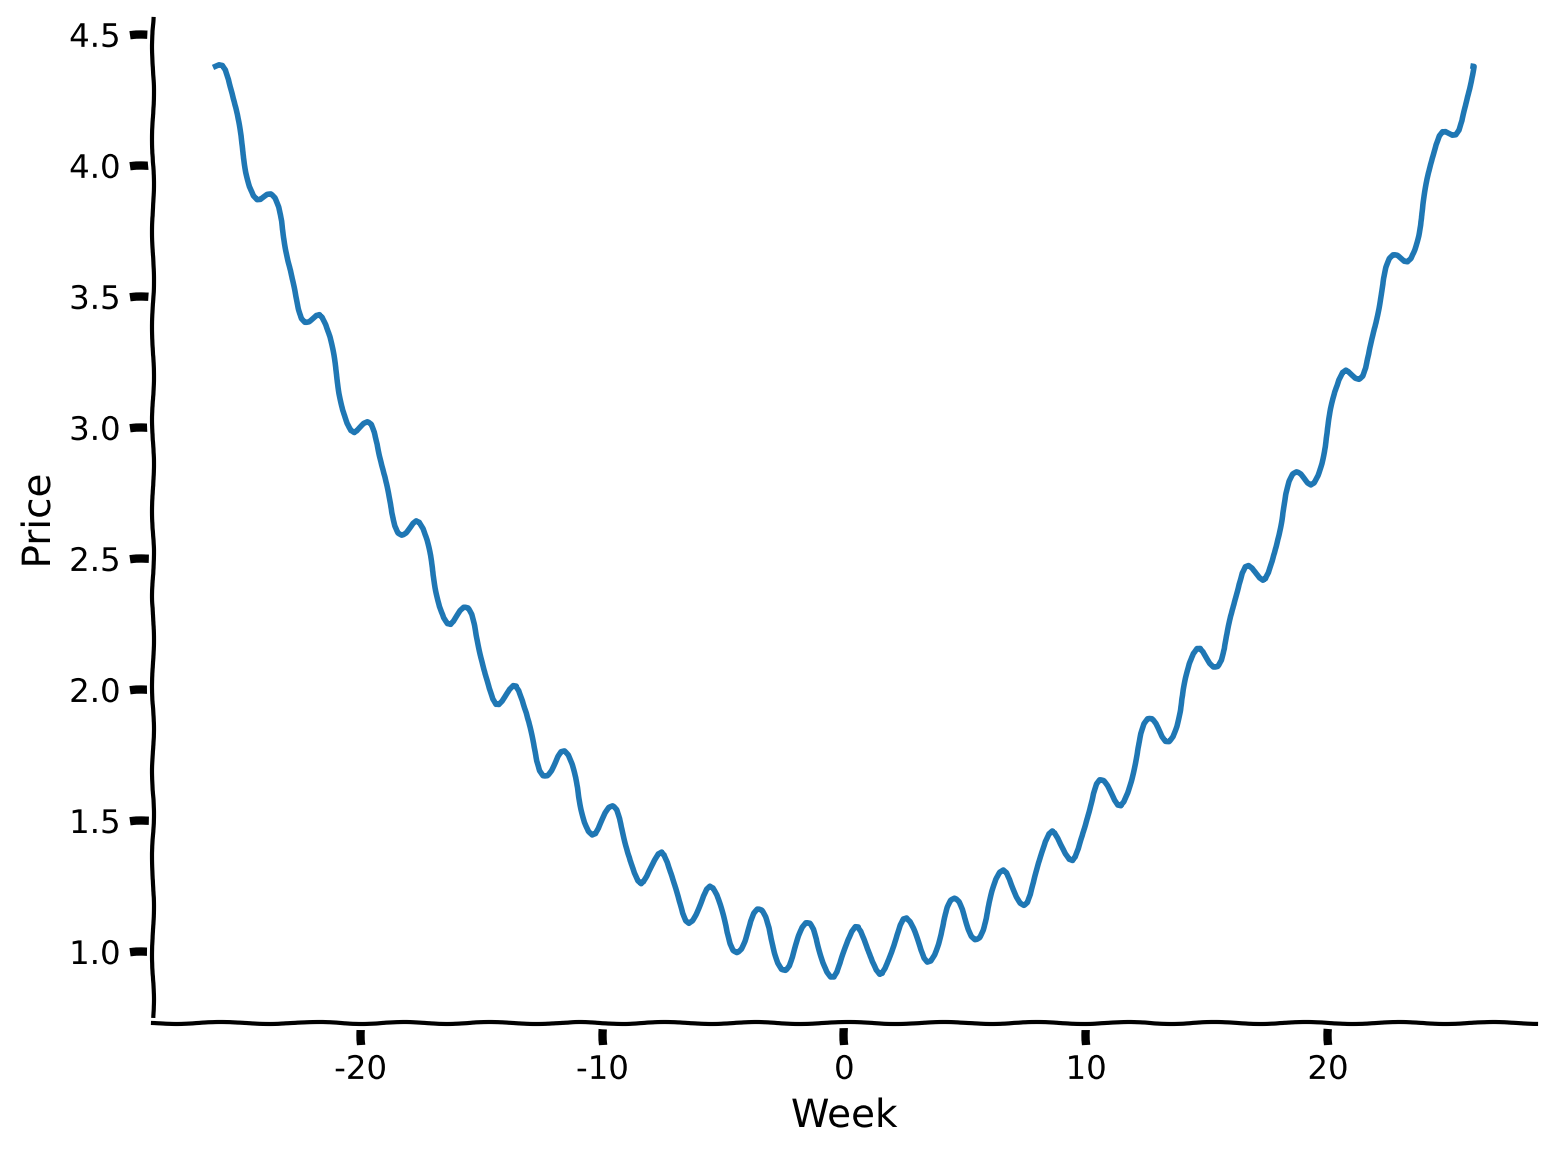

In [8]:
#define variables
A = .005
B = 0.1
phi = 0
C = 1

#define days (observe that those are not 1, ..., 365 but proxy ones to make model function neat)
days = np.arange(-26, 26 + 1/7, 1/7) #defined as fractions of a week

###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: need to complete days-prices relation formula")
###################################################################
prices = A * days **2 + B * np.sin(np.pi * days + phi) + C

#plot relation between days and prices
with plt.xkcd():
  plt.plot(days, prices)
  plt.xlabel('Week')
  plt.ylabel('Price')
  plt.show()

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial1_Solution_59146784.py)

*Example output:*

<img alt='Solution hint' align='left' width=778.0 height=577.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W2D4_Macrolearning/static/W2D4_Tutorial1_Solution_59146784_0.png>



Let's ensure that we indeed have 365 days and 26 local maxima (which equals the number of weeks divided by two, as we receive new supplies bi-weekly).

In [9]:
print(f"The number of days is {days.shape[0]}.")

The number of days is 365.


In [10]:
print(f"The number of peaks is {np.sum((np.diff(prices)[:-1] > 0) & (np.diff(prices)[1:] < 0))}.")

The number of peaks is 26.


Notice that x-axis values start from `-26` and up to `26`, where `-26` represents the start of the year season (January), `0` represents the middle of the year (June-July, having the lowest price of the fruits), and `26` ends the year with December. As we have 52 weeks in the year, the value explicitly describes the week before (if it comes with a minus sign) or after the week in the middle of the year.

**Now, we are ready to train the model to predict the price of the fruits.** First, we will assume we have only been to the market during summer and so only have that data to train on. For this, we need to take data only from the summer months and feed it into the MLP.

As usual, the data will be separated into two distinct classes: train and test. We will measure its performance using the R-squared metric. We will also normalize the data to provide better learning stability for the model.

The MLP consists of two hidden layers, with 100 neurons in each. We use `LBFGS` as the solver for this particular scenario as it performs better compared to `Adam` or `SGD` when the number of data points is limited.

In [20]:
#take only summer data
summer_days = np.expand_dims(days[151:243], 1)
summer_prices = prices[151:243]

#divide data into train and test sets
summer_days_train, summer_days_test, summer_prices_train, summer_prices_test = train_test_split(summer_days, summer_prices, random_state = 42)

###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: need to normalized days and to fit model with it")
###################################################################

#apply normalization for days
summer_days_mean, summer_days_std = np.mean(summer_days), np.std(summer_days)
summer_days_train_norm = (summer_days_train - summer_days_mean) / summer_days_std
summer_days_test_norm = (summer_days_test - summer_days_mean) / summer_days_std

#define MLP
model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, random_state = 42, solver = "lbfgs") # LBFGS is better to use when there is small amount of data

#train MLP
model.fit(summer_days_train, summer_prices_train)

#evaluate MLP on test data
print(f"R-squared value is: {model.score(summer_days_test_norm, summer_prices_test):.02f}.")

R-squared value is: -0.73.


[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial1_Solution_0b85ba35.py)



Let's explore the predictions of the model visually.

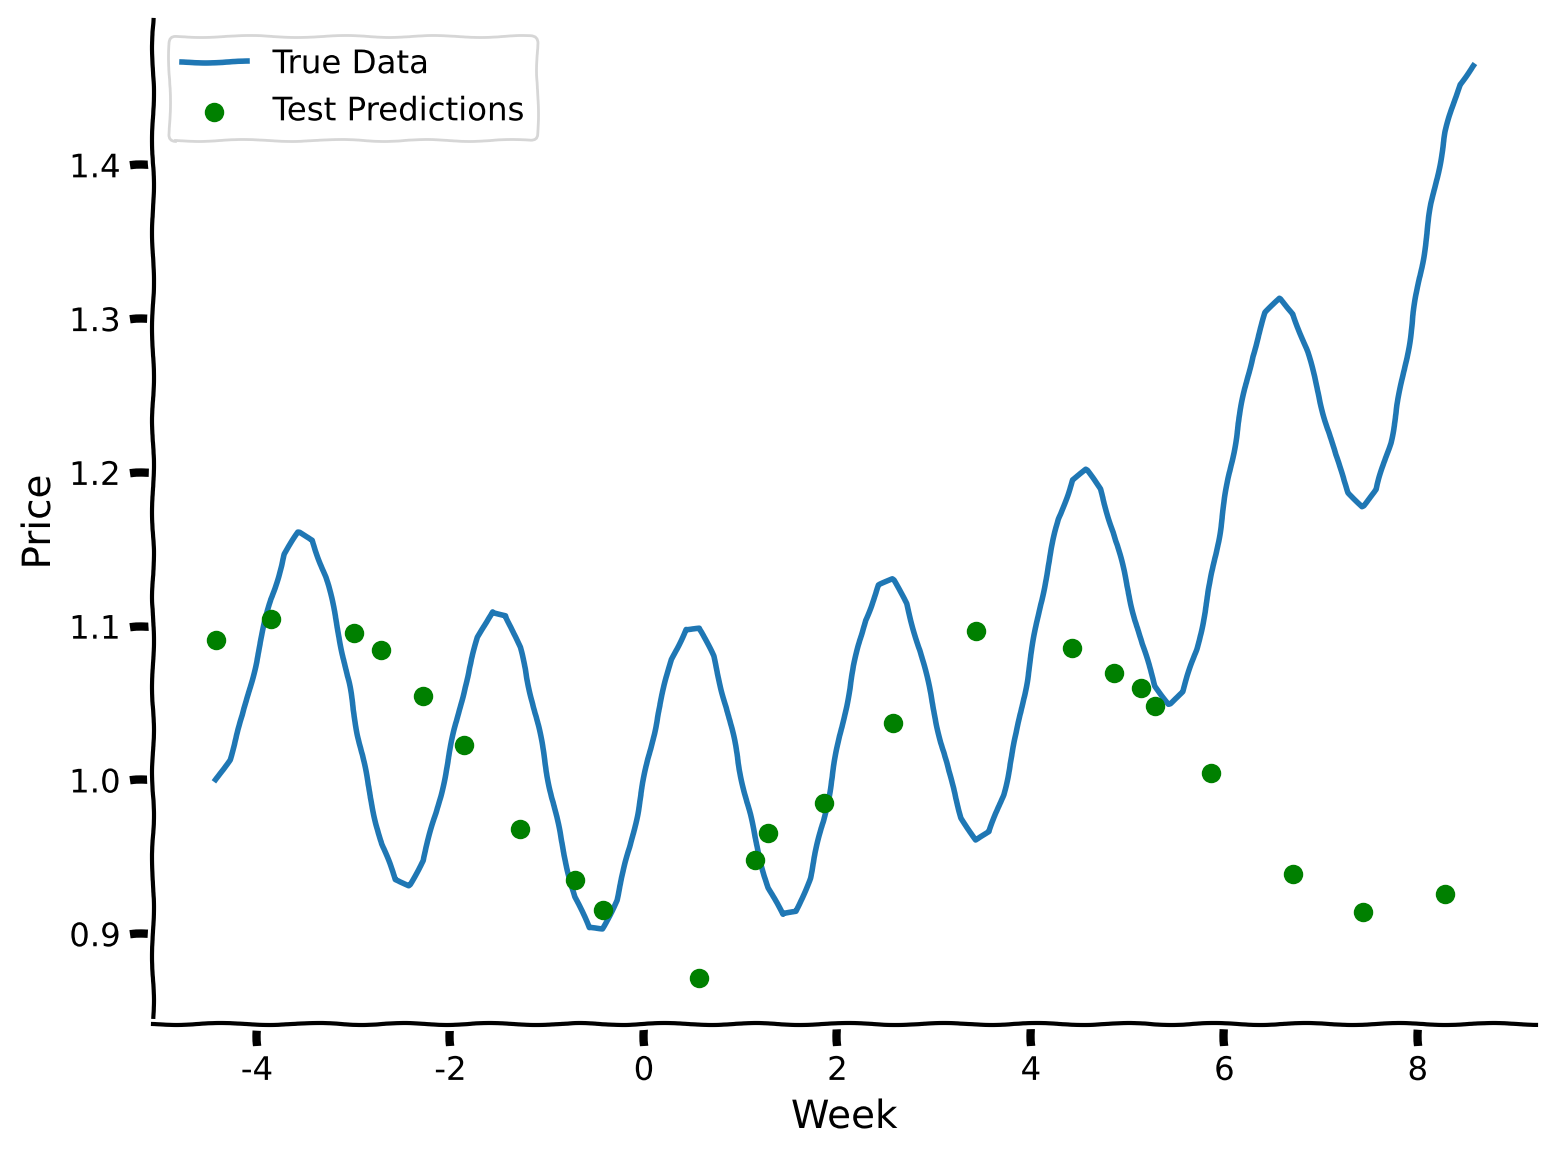

In [14]:
# @title Make sure you execute this cell to observe the plot!

#predict for test set
summer_prices_test_predictions = model.predict(summer_days_test_norm)

with plt.xkcd():
  plt.plot(summer_days, summer_prices, label = "True Data")
  plt.scatter(summer_days_test, summer_prices_test_predictions, label = "Test Predictions", marker='o', color='g', zorder=2)
  plt.xlabel('Week')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

Now that we've learned about prices during the summer, can we predict what prices will be in autumn? Let's see how well our summer-trained model performs.

In [15]:
#take only autumn data
autumn_days = np.expand_dims(days[243:334], 1)
autumn_prices = prices[243:334]

#apply normalization (pay attention to the fact that we use summer metrics as the model was trained on them!)
autumn_days_norm = (autumn_days - summer_days_mean) / summer_days_std

#evaluate MLP on normalized autumn data
print(f"R-squared value is: {model.score(autumn_days_norm, autumn_prices):.02f}.")

R-squared value is: -3.84.


The R-squared value dropped significantly; let's observe what is going on visually.

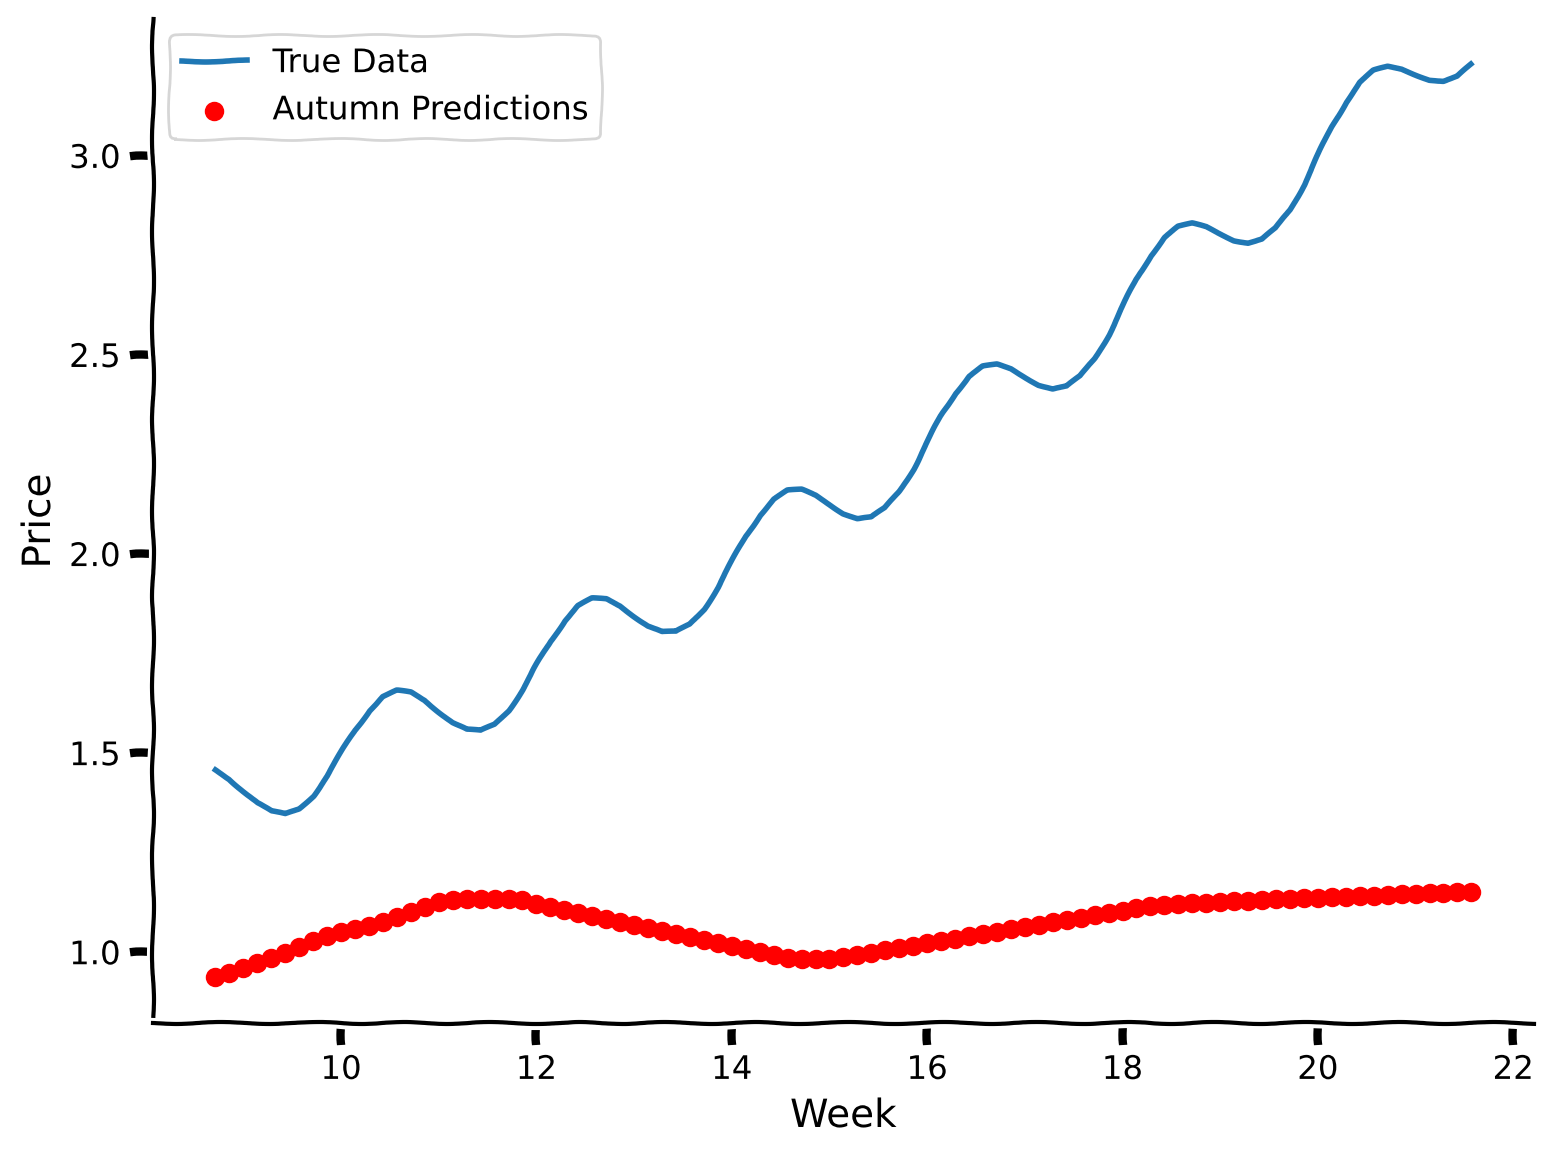

In [16]:
# @title Make sure you execute this cell to observe the plot!

#predict for test set
autumn_prices_predictions = model.predict(autumn_days_norm)

with plt.xkcd():
  plt.plot(autumn_days, autumn_prices, label = "True Data")
  plt.scatter(autumn_days, autumn_prices_predictions, label = "Autumn Predictions", marker='o', color='r', zorder=2)
  plt.xlabel('Week')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

### Coding Exercise 1 Discussion

1. How would you qualitatively evaluate the model's performance on autumn data? Does it capture the annual trend? Does it capture the weekly trend?


[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial1_Solution_4dea007f.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_fitting_pricing_data_to_mlp")

## Interactive Demo 1: Covariate shift impact on predictability power

In this interactive demo, you will explore how well the model generalizes to other months using two dropdown menus for selecting the start and end months for testing data.

!N.B.: Note that for summer months, some training data will also be included in the evaluation of the prediction.

In [17]:
# @markdown Make sure you execute this cell to enable the widget!

@widgets.interact
def interactive_predict(start_month = widgets.Dropdown(description = "Start Month", options = months, value = "June"), end_month = widgets.Dropdown(description = "End Month", options = months, value = "October")):
    predict(days, prices, summer_days_mean, summer_days_std, start_month, end_month)

interactive(children=(Dropdown(description='Start Month', index=5, options=('January', 'February', 'March', 'A…

### Interactive Demo 1 Discussion

1. Does the amount of covariate shift impact the model's performance? What happens at the borders of the training period—does the model still capture the dynamics right before and after it?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial1_Solution_41fdc825.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_covariate_shift_impact_on_predictability_power")

---

# Section 2: Concept shift

*Estimated time to reach this point from the start of the tutorial: 15 minutes*

In this section, we are going to explore another case of distribution shift, which is different in nature from covariate shift: concept shift. This is when the distribution of the inputs, $P(X)$ remains stable, but the mapping from features to predictions, $P(Y|X)$, differs between training and testing data distributions.

## Exercise 2: Change in the day of supply

We observed how transitioning from summer to autumn introduces covariate shifts, but what would lead to a concept shift in our fruit price relationship? One possibility is a change in the day of the week when fresh fruits are delivered. Let's revisit the modeling equation:

$$f(x) = A x^{2} + B sin(\pi x + \phi) + C$$

Which variable, do you think, needs to be changed so that we now receive fresh fruits 2 days later than before?
<details>
<summary>Answer</summary>
<br>
Yes, indeed, it involves a sinusoidal phase shift — we only need to change the phi value.
</details>

Let's take a look at how well the model generalizes to this unexpected change as well.

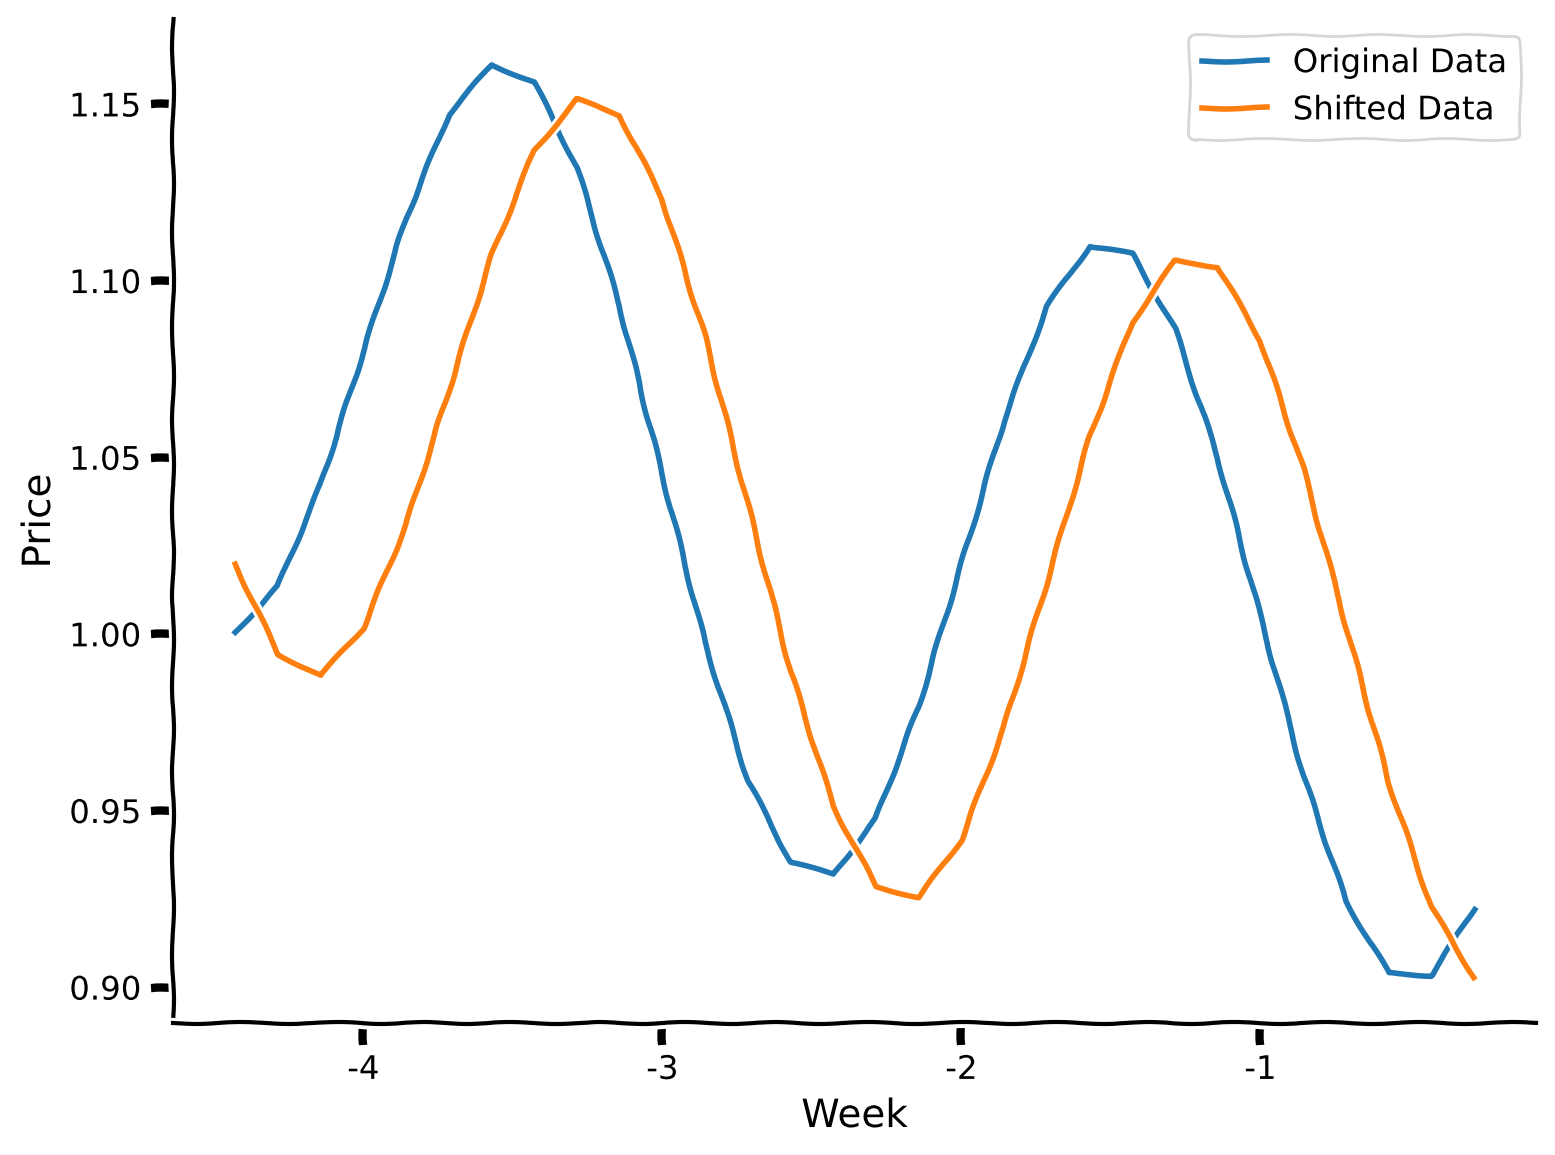

In [18]:
shifted_phi = - 2 * np.pi / 7
shifted_prices = A * days**2 + B * np.sin(np.pi*days + shifted_phi) + C

#plot relation between days, prices & shifted prices for June
with plt.xkcd():
  plt.plot(days[151:181], prices[151:181], label = "Original Data")
  plt.plot(days[151:181], shifted_prices[151:181], label = "Shifted Data")
  plt.xlabel('Week')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

In [19]:
#take only summer shifted data
summer_days = np.expand_dims(days[151:243], 1)
summer_prices_shifted = shifted_prices[151:243]

#apply normalization (pay attention to the fact that we use summer metrics as the model was trained on them!)
summer_days_norm = (summer_days - summer_days_mean) / summer_days_std

#evaluate MLP on normalized original & shifted data
print(f"R-squared value for original prices is: {model.score(summer_days_norm, summer_prices):.02f}.")
print(f"R-squared value for shifted prices is: {model.score(summer_days_norm, summer_prices_shifted):.02f}.")

R-squared value for original prices is: -1.12.
R-squared value for shifted prices is: -1.16.


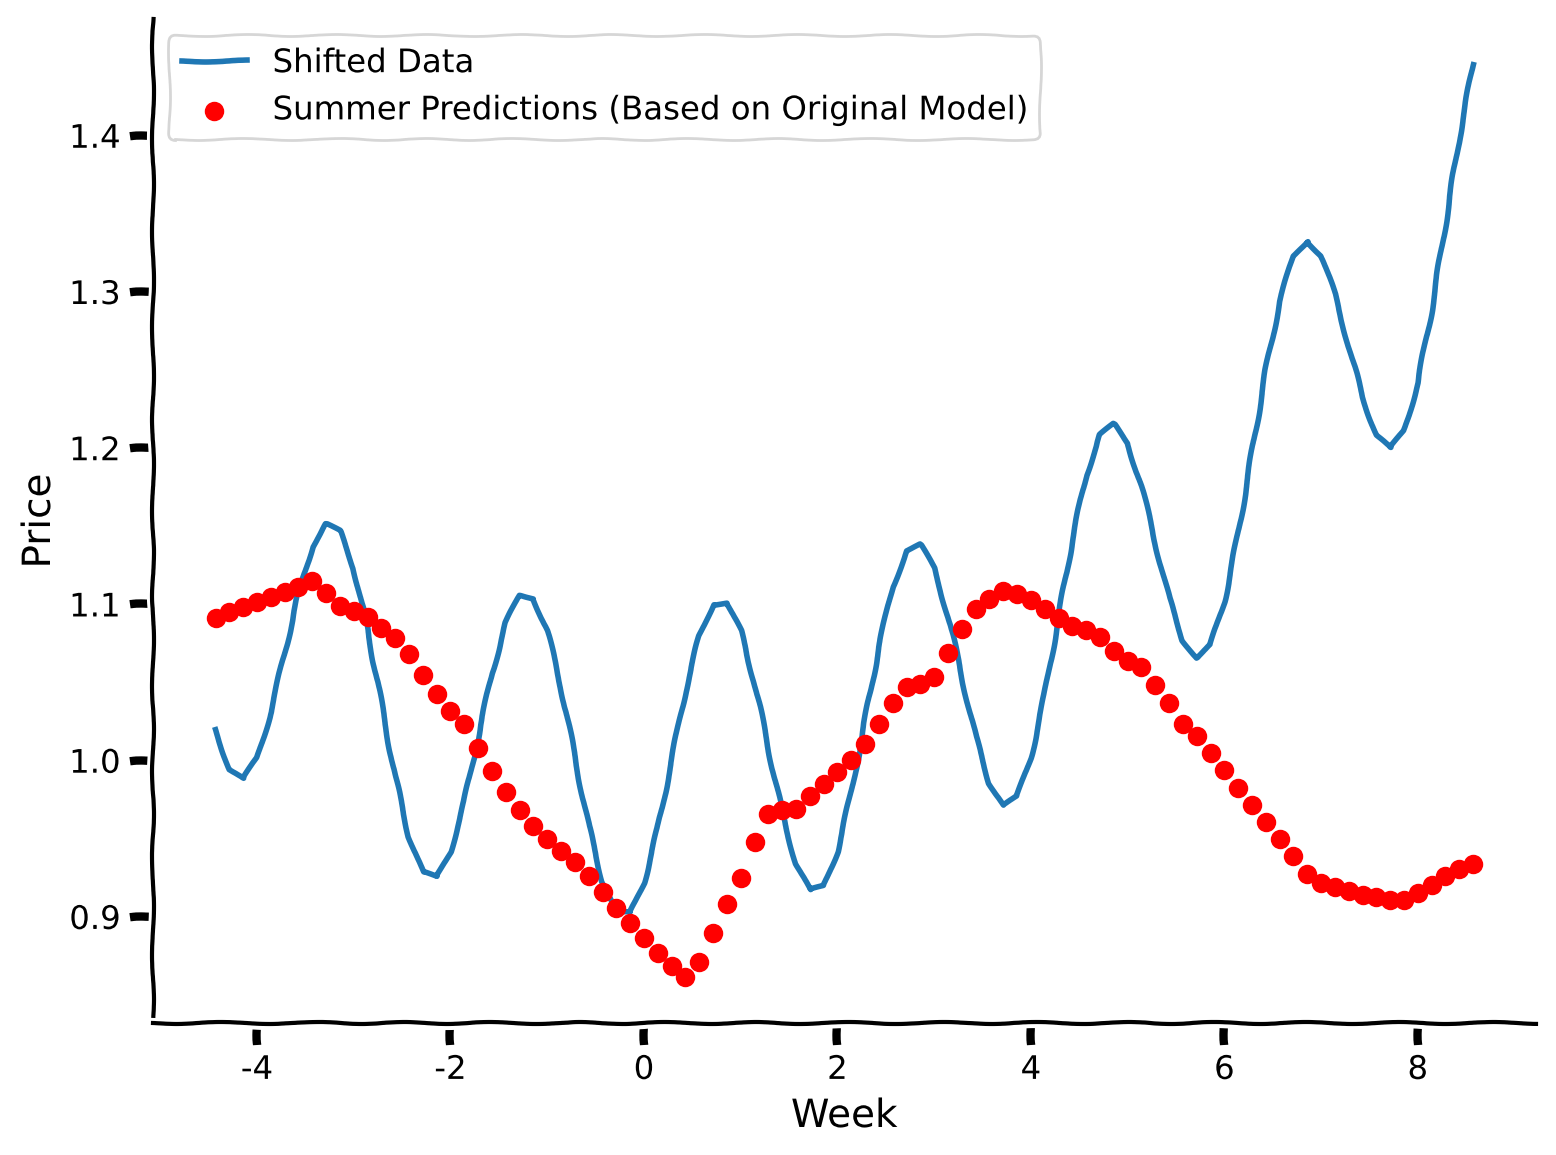

In [21]:
# @title Make sure you execute this cell to observe the plot!

#predict for summer days
summer_prices_predictions = model.predict(summer_days_norm)

with plt.xkcd():
  plt.plot(summer_days, summer_prices_shifted, label = "Shifted Data")
  plt.scatter(summer_days, summer_prices_predictions, label = "Summer Predictions (Based on Original Model)", marker='o', color='r', zorder=2)
  plt.xlabel('Week')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

The model's predictions are capturing the original phase, not the phase-shifted function. Well, it's somewhat expected: we fixed values of features (in this case, week number), trained at first on one set of output values (prices), and then changed the outputs to measure the model's performance. It's obvious that the model will perform badly. Still, it's important to notice the effect of concept shift and this translation between conceptual effect and its impact on modeling.

### Exercise 2 Discussion

1. Why do you think the R-squared value is still higher for this particular example of concept shift compared to the covariate shift?

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W2D4_Macrolearning/solutions/W2D4_Tutorial1_Solution_35e7f912.py)



In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_change_in_the_day_of_supply")

---

## Think!: Examples of concept shift

What other examples of concept shift could you come up with in the context of the "fruit prices" task? What variables would these shifts impact?

Take 2 minutes to think, then discuss as a group.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_examples_of_concept_shift")

---
# Summary

*Estimated timing of tutorial: 30 minutes*

Here's what we learned:

1. Covariate and concept shifts are two different types of data distribution shifts.
2. Distribution shifts negatively impact model performance.

# The Big Picture

Distribution shifts are a huge issue in modern ML systems. Awareness of the fundamental idea behind how these shifts can happen is increasingly important, the more that these systems take on roles that impact systems that we interact with in our daily lives. During COVID-19, product replenishment systems failed spectacularly because there was an underlying shift (panic buying of certain items) that the model did not expect and this caused a huge problem for systems that relied on statistical predictions in the company pipeline.

In NeuroAI, the distribution shifts can happen in numerous places. For example, training a model on sets of neurons that belong to different brain areas or perhaps the same distribution of neurons that differ due to a confounding third factor, that renders the training and test distribution of features to be different. Awareness of potential distribution shifts is incredibly important and should be something systems are continuosly monitoring. NeuroAI currently lags behind in its adoption of evaluations that monitor these kinds of issues. Our goal is to bring this attention more to the forefront so that in your careers as NeuroAI practioners, you are aware of the necessary factors that can affect the models you build.

In the next tutorials, we are going to address the question of generalization—what are the techniques and methods to deal with poor generalization performance due to distribution shifts.